In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from scipy import stats
from scipy import signal
from statsmodels.graphics.api import qqplot

import os
import sys #only needed to determine the python version number
from six import string_types

import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline
print("Python version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Statsmodels version: {}".format(sm.version.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.22.0
Statsmodels version: 0.8.0
Matplotlib version: 2.2.2


# A Visual Tour of Time Series:  Practice

## Some Utility Classes

In [124]:
class RollingPlots(object):
    """A Class with methods to create rolling plots for Pandas Series."""
    
    def __init__(self, tseries=None, window=24, center=False, figsize=(14,8)):
        """
        Arguments:
            tseries (Pandas Series): Pandas Series object containing time
                series to plot
            window (int): The size of the moving window for the rolling plots
            center (bool): Center the window (or use a trailing window)?
            figsize (int, int): Specify the size of the matplotlib plot
        """

        self._window = window
        self._figsize = figsize
        self._center = center
        self._tseries = tseries

    @property
    def window(self):
        return self._window

    @window.setter
    def window(self, window):
        self._window = window

    @property
    def center(self):
        return self._center

    @center.setter
    def center(self, center):
        self._center = center

    @property
    def figsize(self):
        return self._figsize

    @figsize.setter
    def figsize(self, figsize):
        self._figsize = figsize

    @property
    def tseries(self):
        return self._tseries

    @tseries.setter
    def tseries(self, tseries):
        self._tseries = tseries

    def _have_series(self):
        return isinstance(self.tseries, pd.Series)

    def rolling_mean(self, title=''):
        """Plot a time series along with its rolling mean"""

        if not self._have_series():
            return

        fig = plt.figure(figsize=self.figsize)
        ts_ax = self.tseries.plot()
        ts_ax.set_title(title)

        rolling = self.tseries.rolling(self.window, center=self.center)
        rolling.mean().plot(ax=ts_ax)

        plt.tight_layout()
        plt.show()

    def rolling_std(self, title=''):
        """Plot the rolling stddev of a time series"""

        if not self._have_series():
            return

        rolling = self.tseries.rolling(self.window, center=self.center)
        ts_ax = rolling.std().plot(figsize=self.figsize)
        ts_ax.set_title(title)

        plt.tight_layout()
        plt.show()

    def rolling_bands(self, nstd=2, title=''):
        """Plot a time series along with its rolling mean and bands of
           nstd (rolling) standard deviations away from the rolling mean.
        
        Arguments:
            nstd (int): The number of standard deviations to use in calculating
                        the bands.
            title (str): The title for the plot.

        Returns:
            None
        """

        if not self._have_series():
            return

        fig = plt.figure(figsize=self.figsize)
        ts_ax = self.tseries.plot()
        ts_ax.set_title(title)

        roll = self.tseries.rolling(self.window, center=self.center)
        m = roll.agg(['mean', 'std'])

        try:
            s = nstd * m['std']
        except TypeError:
            print("Invalid type input for nstd.  Using default value of 2.")
            s = 2 * m['std']

        m['mean'].plot(ax=ts_ax)
        ts_ax.fill_between(m.index, m['mean'] - s, m['mean'] + s, alpha=0.25)
        plt.tight_layout()

    def tsplot(self, lags=None, figsize=None, title=''):
        """Examine the patterns of ACF and PACF, along with the time series plot and histogram.

        Arguments:
            lags (int): The number of lags to use the ACF and PACF
            title (str): The title to associate with the plot
            figsize (int, int): Specifies the width and height of the plot

        Returns:
            None

        Slight modification of code from Tom Augspurger's github site:
        https://tomaugspurger.github.io/modern-7-timeseries.html
        """

        if not self._have_series():
            return

        fsize = figsize or self.figsize
        order = lags or 12
        y = self.tseries

        fig = plt.figure(figsize=fsize)
        layout = (2, 2)
        ts_ax   = plt.subplot2grid(layout, (0, 0))
        hist_ax = plt.subplot2grid(layout, (0, 1))
        acf_ax  = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        y.plot(ax=hist_ax, kind='hist', bins=25)
        hist_ax.set_title('Histogram')
        smt.graphics.plot_acf(y, lags=order, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=order, ax=pacf_ax)
        [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
        fig.tight_layout()
        return ts_ax, acf_ax, pacf_ax

In [125]:
def plot_periodogram(time_series, sampling_frequency=1.0):
    """Plot the power spectral density of the time series"""

    frequencies, samples = signal.periodogram(time_series, fs=sampling_frequency, return_onesided=True, scaling='spectrum')
    psd_series = pd.Series(data=samples, index=frequencies)
    psd_series.plot(figsize=(12,8))
    plt.show()

## Some Practice Ideas

### Read in the weekly CO2 data provided by statsmodels and try some of the steps from the notebook: "A Visual Tour of Time Series". 

In [126]:
co2_dataset = sm.datasets.co2.load_pandas()
df1 = co2_dataset.data
s = df1.loc[:,'co2'].interpolate()
s.head()

1958-03-29    316.1
1958-04-05    317.3
1958-04-12    317.6
1958-04-19    317.5
1958-04-26    316.4
Freq: W-SAT, Name: co2, dtype: float64

In [127]:
rp = RollingPlots(tseries=s, window=52, center=True)

## Sunspots Dataset
The sunspots data set is frequently used when showing how AR models work.  The data is loaded here.  Try playing with different visualization techniques using this time series.

Visit www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma0.html if you want to see a "cheat sheet" for this data set.
This data set also appears in a number of books and online resources.

In [128]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [129]:
df_sunspot = sm.datasets.sunspots.load_pandas().data

In [130]:
df_sunspot.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [131]:
df_sunspot.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
df_sunspot.drop(columns='YEAR', inplace=True)
df_sunspot.head()

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


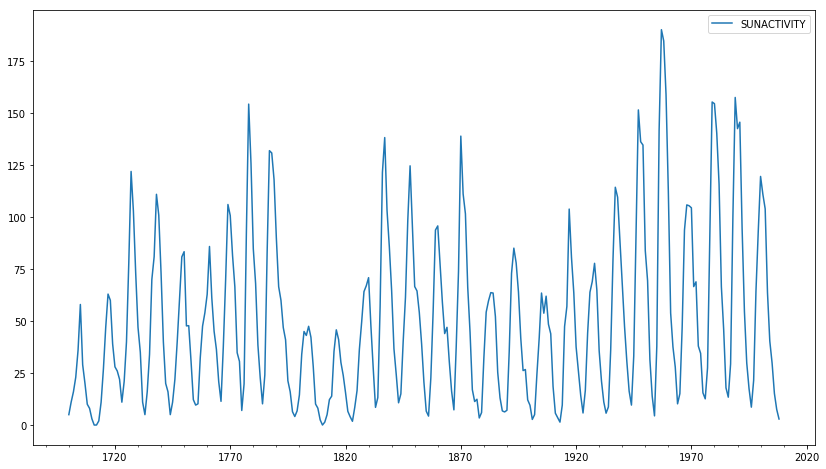

In [132]:
df_sunspot.plot(figsize=(14,8))

www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_1.html describes how to create artificial data for testing.  (For your convenience, the first part of the example in "tsa_arma_1" is recreated below.)  Try creating some artificial data and then use some of the visualization tools from the presentation.

In [133]:
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(12345)

ar_params = np.array([0.75,-0.25])
ma_params = np.array([0.65, 0.35])

ar_params = np.r_[1, -ar_params]
ma_params = np.r_[1, ma_params]
nobs = 250
y = arma_generate_sample(ar_params, ma_params, nobs)

In [134]:
dates = sm.tsa.datetools.dates_from_range('1980m1', length=nobs)
y = pd.Series(y, index=dates)
y.head()

1980-01-31   -0.204708
1980-02-29    0.192353
1980-03-31   -0.084332
1980-04-30   -0.837072
1980-05-31    0.816031
dtype: float64

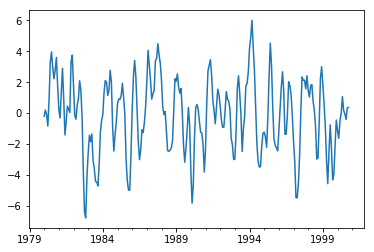

In [135]:
y.plot()